In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/captcha-image-dataset/captchas/test/9920_ase2rm.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/8560_dehtnt.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9019_fecrvk.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/8669_2fehek.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9169_zekzpx.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9771_a22ggt.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9720_zbhebd.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9254_azuuab.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9002_bvsdsx.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/8612_2uackv.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9860_6ggpvp.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9599_dd2kun.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9216_dn6v6g.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9240_cg2avr.jpeg
/kaggle/input/captcha-image-dataset/captchas/test/9125_kdrxen.

In [ ]:
#%matplotlib inline
import tensorflow as tf
import keras
from keras import layers
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, Activation, LeakyReLU, Conv2D, Conv2DTranspose, Input
#from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.datasets import mnist
import numpy as np
from keras.models import Model
from keras.initializers import RandomNormal

import matplotlib.pyplot as plt
from PIL import Image

import os
DATASET_PATH = "/kaggle/input/captcha-image-dataset/captchas/train"

import tensorflow_addons as tfa
from tensorflow_addons.layers import InstanceNormalization



class DCGAN:
    def __init__(self, image_rows, image_columns, image_channels, z_dim, batch_size, epochs, dataset_path):
        self.z_dim = z_dim
        self.batch_size = batch_size
        self.epochs = epochs
        self.images_rows = image_rows
        self.image_columns = image_columns
        self.image_channels = image_channels
        self.initializer = RandomNormal(stddev=0.02)
        self.build_discriminator()
        self.build_generator()
        self.build_adversarial()
        self.dataset_path = dataset_path
        self.d_loss = []
        self.g_loss = []
        # Create a checkpoint directory
        checkpoint_dir = './model_saves'
        os.makedirs(checkpoint_dir, exist_ok=True)
    def build_discriminator(self):
        x = Input(shape=(self.images_rows,self.image_columns,self.image_channels))
        discriminator_input=x
        x = Conv2D(32, kernel_size=3, strides=2,padding='same',kernel_initializer=self.initializer)(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(64, kernel_size=3, strides=2,padding='same',kernel_initializer=self.initializer)(x)
        #x = BatchNormalization()(x)
        x = InstanceNormalization(axis=3,
                                   center=True,
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Conv2D(128, kernel_size=3, strides=2,padding='same',kernel_initializer=self.initializer)(x)
        #x = BatchNormalization()(x)
        x = InstanceNormalization(axis=3,
                                   center=True,
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = Flatten()(x)
        discriminator_output = Dense(1, activation="sigmoid")(x)
        self.discriminator = Model(discriminator_input, discriminator_output)
        self.discriminator.compile(optimizer='adam', loss="binary_crossentropy")
        
    def build_generator(self):
        x = Input(shape=self.z_dim)
        generator_input = x
        x = Dense(256*32*7)(x)
        x = Reshape((7,32,256))(x)
        x = Conv2DTranspose(128, kernel_size=3, strides=2, padding='same',kernel_initializer=self.initializer)(x)       
        #x = BatchNormalization()(x)
        x = InstanceNormalization(axis=3,
                                   center=True,
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")(x)
        x= LeakyReLU(alpha=0.1)(x)
        x = Conv2DTranspose(64, kernel_size=3, strides=2, padding='same',kernel_initializer=self.initializer)(x)  
        #x = BatchNormalization()(x)
        x = InstanceNormalization(axis=3,
                                   center=True,
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")(x)
        x= LeakyReLU(alpha=0.1)(x)
        x = Conv2D(32, kernel_size=4, strides=1,kernel_initializer=self.initializer)(x)
        x = InstanceNormalization(axis=3,
                                   center=True,
                                   scale=True,
                                   beta_initializer="random_uniform",
                                   gamma_initializer="random_uniform")(x)
        x= LeakyReLU(alpha=0.1)(x)
        x = Conv2DTranspose(1, kernel_size=3, strides=2, padding='same',kernel_initializer=self.initializer)(x) 
        generator_output = Activation('tanh')(x)
        self.generator = Model(generator_input, generator_output)
    
    def build_adversarial(self):
        self.discriminator.trainable = False
        gan_input = Input(shape=self.z_dim)
        generated_image = self.generator(gan_input)
        gan_output = self.discriminator(generated_image)
        self.gan = Model(gan_input, gan_output)
        self.gan.compile(optimizer='adam', loss="binary_crossentropy")
    
    def train_discriminator(self, real_images, fake_images):
        valid_labels = np.ones((real_images.shape[0],1))
        fake_labels = np.zeros((fake_images.shape[0],1))
        valid_loss = self.discriminator.train_on_batch(real_images, valid_labels)
        fake_loss = self.discriminator.train_on_batch(fake_images, fake_labels)
        return 0.5*fake_loss + 0.5*valid_loss
    
    def train_generator(self, noise):
        generated_labels = np.ones((noise.shape[0],1))
        g_loss = self.gan.train_on_batch(noise, generated_labels)
        return g_loss
    
    def load_mnist(self):
        (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
        train_images.reshape(-1, 28, 28, 1).astype('float32')
        rescaled_images =  (train_images.astype(np.float32) - 127.5) / 127.5  # Normalize the images to [-1, 1]
        return rescaled_images
    


    def load_images_from_path(self):
        image_list = []

        # Iterate through all files in the directory
        for filename in os.listdir(self.dataset_path):
            if filename.endswith(".jpeg"):
                # Construct the full file path
                file_path = os.path.join(self.dataset_path, filename)
                
                # Open the image, convert to grayscale (if needed), and convert to NumPy array
                image = Image.open(file_path).convert('L')  # 'L' mode for grayscale
                image_array = np.array(image)

                # Append the NumPy array to the list
                image_list.append(image_array)

        image_list = np.array(image_list)
        image_list = np.expand_dims(image_list, axis=-1)
        rescaled_images =  (image_list.astype(np.float32) - 127.5) / 127.5  # Normalize the images to [-1, 1]
        return rescaled_images


    def train_gan(self, sample_interval=100):
        rescaled_images = self.load_images_from_path()
        for epoch in range(self.epochs):
            noise = np.random.normal(0, 1, (self.batch_size, self.z_dim))
            idx = np.random.randint(0, rescaled_images.shape[0], self.batch_size)
            real_images = rescaled_images[idx]
            fake_images = self.generator.predict(noise)
            d_loss_epoch = self.train_discriminator(real_images, fake_images)
            self.d_loss.append(d_loss_epoch)
            noise = np.random.normal(0, 1, (self.batch_size, self.z_dim))
            g_loss_epoch = self.train_generator(noise)
            self.g_loss.append(g_loss_epoch)
            if (epoch + 1) % sample_interval == 0:
                print("epoch: {} g_loss: {} d_loss {}". format(epoch+1, g_loss_epoch, d_loss_epoch))

                # Save losses and accuracies so they can be plotted after training
                #losses.append((d_loss, g_loss))
                #accuracies.append(100.0 * accuracy)
                #iteration_checkpoints.append(iteration + 1)

                # Output training progress
                #print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %
                #    (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

                # Output a sample of generated image
                self.sample_images()
            if (epoch + 1) % 1000 == 0:
              self.discriminator.save("/model_saves/discriminator_DCGAN_epoch{}.h5".format(epoch+1))
              self.generator.save("/model_saves/generator_DCGAN_epoch{}.h5".format(epoch+1))


    def sample_images(self, image_grid_rows=4, image_grid_columns=3):

        # Sample random noise
        z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, self.z_dim))

        # Generate images from random noise
        gen_imgs = self.generator.predict(z)

        # Rescale image pixel values to [0, 1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        # Set image grid
        fig, axs = plt.subplots(image_grid_rows,
                                image_grid_columns,
                                figsize=(25, 5),
                                sharey=True,
                                sharex=True)

        cnt = 0
        for i in range(image_grid_rows):
            for j in range(image_grid_columns):
                # Output a grid of images
                axs[i, j].imshow(gen_imgs[cnt,:,:,:], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()
    
if __name__ == "__main__":
    BATCH_SIZE = 64
    EPOCHS = 10000
    #code to acquire image dimensions, the dimensions are width = 250 , height = 50
    # def getImageDimension(path):
    #     im = Image.open(path)
    #     width, height = im.size
    #     return width, height
    # print(getImageDimension(r"C:\Models\DCGAN_CAPTCHA\captchas\train\0_vgxrub.jpeg"))
    GAN = DCGAN(image_rows=50, image_columns=250, image_channels=1, z_dim=100, batch_size=BATCH_SIZE, epochs=EPOCHS, dataset_path=DATASET_PATH)
    train_images = GAN.load_images_from_path()
    print(train_images[0].shape)
    print(len(train_images))
    GAN.train_gan()
    fig, ax = plt.subplots()
    ax.plot(GAN.d_loss, label='Discriminator Loss')
    ax.plot(GAN.g_loss, label='Generator Loss')
    ax.legend()
    plt.show()

1/1 [==============================] - 0s 19ms/step


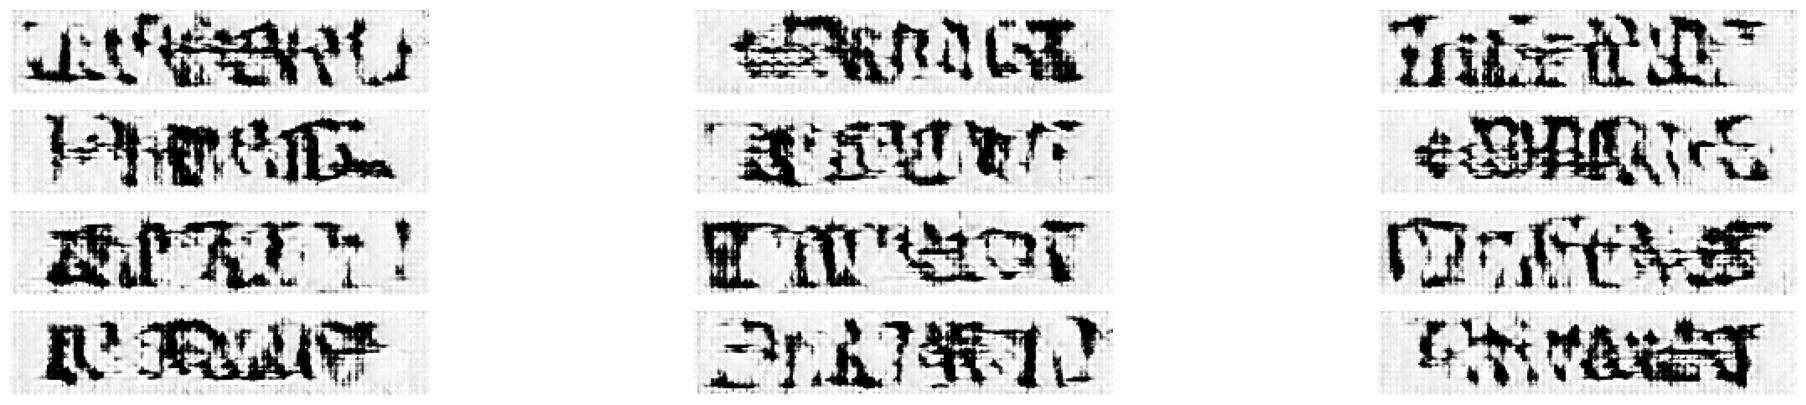

In [51]:
my_fig = GAN.sample_images()

#my_fig.savePlot("captchas.png")

In [32]:
GAN.discriminator.save("discriminator.h5")

In [31]:
GAN.generator.save("generator.h5")